# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [12]:
import numpy as np
import os
import imageio
from imageio import imread
from skimage.transform import resize as imresize
#from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [13]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.random.set_seed(30)
tf.set_random_seed(30)

In [14]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

In [16]:
project_folder='Project_data'

##### Plotting

In [17]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [18]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [19]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

## Experimenting with Image resolution, number of frames to use and batchsize

In [21]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [58]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6721 - categorical_accuracy: 0.4057 
Epoch 00001: saving model to model_init_2020-12-2717_22_22.908573\model-00001-1.67206-0.40573-2.47648-0.16000.h5
23/23 [==============================] - 497s 22s/step - loss: 1.6721 - categorical_accuracy: 0.4057 - val_loss: 2.4765 - val_categorical_accuracy: 0.1600
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0124 - categorical_accuracy: 0.6063 
Epoch 00002: saving model to model_init_2020-12-2717_22_22.908573\model-00002-1.01240-0.60633-5.02390-0.16000.h5
23/23 [==============================] - 484s 21s/step - loss: 1.0124 - categorical_accuracy: 0.6063 - val_loss: 5.0239 - val_categorical_accuracy: 0.1600


In [59]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.6544 - categorical_accuracy: 0.4057 
Epoch 00001: saving model to model_init_2020-12-2717_39_50.865525\model-00001-1.65439-0.40573-1.77989-0.16000.h5
12/12 [==============================] - 256s 21s/step - loss: 1.6544 - categorical_accuracy: 0.4057 - val_loss: 1.7799 - val_categorical_accuracy: 0.1600
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.0963 - categorical_accuracy: 0.5686 
Epoch 00002: saving model to model_init_2020-12-2717_39_50.865525\model-00002-1.09629-0.56863-2.54668-0.16000.h5
12/12 [==============================] - 255s 21s/step - loss: 1.0963 - categorical_accuracy: 0.5686 - val_loss: 2.5467 - val_categorical_accuracy: 0.1600


In [60]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6198 - categorical_accuracy: 0.4253 
Epoch 00001: saving model to model_init_2020-12-2717_49_29.816868\model-00001-1.61976-0.42534-7.03640-0.21000.h5
45/45 [==============================] - 1270s 28s/step - loss: 1.6198 - categorical_accuracy: 0.4253 - val_loss: 7.0364 - val_categorical_accuracy: 0.2100
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0007 - categorical_accuracy: 0.6440 
Epoch 00002: saving model to model_init_2020-12-2717_49_29.816868\model-00002-1.00067-0.64404-9.74501-0.18000.h5
45/45 [==============================] - 1259s 28s/step - loss: 1.0007 - categorical_accuracy: 0.6440 - val_loss: 9.7450 - val_categorical_accuracy: 0.1800


In [61]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.4509 - categorical_accuracy: 0.4434 
Epoch 00001: saving model to model_init_2020-12-2718_32_52.811347\model-00001-1.45087-0.44344-2.75097-0.16000.h5
45/45 [==============================] - 656s 15s/step - loss: 1.4509 - categorical_accuracy: 0.4434 - val_loss: 2.7510 - val_categorical_accuracy: 0.1600
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.8700 - categorical_accuracy: 0.6576 
Epoch 00002: saving model to model_init_2020-12-2718_32_52.811347\model-00002-0.87002-0.65762-5.12635-0.15000.h5
45/45 [==============================] - 660s 15s/step - loss: 0.8700 - categorical_accuracy: 0.6576 - val_loss: 5.1263 - val_categorical_accuracy: 0.1500


In [62]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5479 - categorical_accuracy: 0.4178
Epoch 00001: saving model to model_init_2020-12-2718_55_27.042545\model-00001-1.54791-0.41780-3.52242-0.16000.h5
45/45 [==============================] - 271s 6s/step - loss: 1.5479 - categorical_accuracy: 0.4178 - val_loss: 3.5224 - val_categorical_accuracy: 0.1600
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0768 - categorical_accuracy: 0.5852
Epoch 00002: saving model to model_init_2020-12-2718_55_27.042545\model-00002-1.07681-0.58522-3.91496-0.14000.h5
45/45 [==============================] - 286s 6s/step - loss: 1.0768 - categorical_accuracy: 0.5852 - val_loss: 3.9150 - val_categorical_accuracy: 0.1400


In [63]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5461 - categorical_accuracy: 0.4072
Epoch 00001: saving model to model_init_2020-12-2719_05_00.742629\model-00001-1.54612-0.40724-7.62300-0.22000.h5
67/67 [==============================] - 540s 8s/step - loss: 1.5461 - categorical_accuracy: 0.4072 - val_loss: 7.6230 - val_categorical_accuracy: 0.2200
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1737 - categorical_accuracy: 0.5505
Epoch 00002: saving model to model_init_2020-12-2719_05_00.742629\model-00002-1.17370-0.55053-11.92631-0.22000.h5
67/67 [==============================] - 521s 8s/step - loss: 1.1737 - categorical_accuracy: 0.5505 - val_loss: 11.9263 - val_categorical_accuracy: 0.2200


In [64]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.3966 - categorical_accuracy: 0.4781 
Epoch 00001: saving model to model_init_2020-12-2719_23_04.098061\model-00001-1.39660-0.47813-3.10225-0.16000.h5
67/67 [==============================] - 694s 10s/step - loss: 1.3966 - categorical_accuracy: 0.4781 - val_loss: 3.1023 - val_categorical_accuracy: 0.1600
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1212 - categorical_accuracy: 0.5913 
Epoch 00002: saving model to model_init_2020-12-2719_23_04.098061\model-00002-1.12116-0.59125-10.80035-0.17000.h5
67/67 [==============================] - 691s 10s/step - loss: 1.1212 - categorical_accuracy: 0.5913 - val_loss: 10.8003 - val_categorical_accuracy: 0.1700


In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5234 - categorical_accuracy: 0.4329 
Epoch 00001: saving model to model_init_2020-12-2719_52_20.221570\model-00001-1.52337-0.43288-2.32933-0.16000.h5
17/17 [==============================] - 955s 56s/step - loss: 1.5234 - categorical_accuracy: 0.4329 - val_loss: 2.3293 - val_categorical_accuracy: 0.1600
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.8527 - categorical_accuracy: 0.6682 
Epoch 00002: saving model to model_init_2020-12-2719_52_20.221570\model-00002-0.85273-0.66817-3.58990-0.18000.h5
17/17 [==============================] - 901s 53s/step - loss: 0.8527 - categorical_accuracy: 0.6682 - val_loss: 3.5899 - val_categorical_accuracy: 0.1800


##### From the above experiments, we find that image resolution & no. of frames in sequence have more impact on training time than batch_size

##### So, we are experimenting with batch size 15-40 and changing the resolution and number of image per sequence based on memory constraints.

# Model 1 

Base Model / No Data Augmentation Batch Size 40, Epoch 15

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.4484 - categorical_accuracy: 0.4555  
Epoch 00001: saving model to model_init_2020-12-2722_24_46.782891\model-00001-1.44844-0.45551-1.58578-0.25000.h5
17/17 [==============================] - 1715s 101s/step - loss: 1.4484 - categorical_accuracy: 0.4555 - val_loss: 1.5858 - val_categorical_accuracy: 0.2500
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.8714 - categorical_accuracy: 0.6350  
Epoch 00002: saving model to model_init_2020-12-2722_24_46.782891\model-00002-0.87136-0.63499-2.24478-0.23000.h5
17/17 [==============================] - 1563s 92s/step - loss: 0.8714 - categorical_accuracy: 0.6350 - val_loss: 2.2448 - val_categorical_accuracy: 0.2300
Epoch 3/15
 9/17 [==============>...............] - ETA: 14:43 - loss: 0.5773 - categorical_accuracy: 0.7639

In [ ]:
plot(history_model1)

We need to do data augmentation as it is visible that the model is over fitting.

# Model 2
Augment Data, (3,3,3) filter & 160x160 image resolution

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

In [ ]:
plot(history_model2)

This model is not overfitting, we are seeing a best validation accuracy of 85% and training accuracy of 91%.

# Model 3
Reducing filter size to (2,2,2) and image resolution to 120 x  120

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

In [ ]:
plot(history_model3)

Model has a best validation accuracy of 84% and training accuracy of 84%.
Also we were able to reduce the parameter size by half the earlier model.
Let's add more layers

# Model 4
Adding more layers

In [12]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [14]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
33/34 [============================>.] - ETA: 9s - loss: 1.8676 - categorical_accuracy: 0.3977 
Epoch 00001: saving model to model_init_2020-12-2804_14_59.844562/model-00001-1.86348-0.39894-1.97870-0.18000.h5
34/34 [==============================] - 356s 10s/step - loss: 1.8414 - categorical_accuracy: 0.4054 - val_loss: 1.9787 - val_categorical_accuracy: 0.1800
Epoch 2/30
33/34 [============================>.] - ETA: 4s - loss: 1.4694 - categorical_accuracy: 0.5129
Epoch 00002: saving model to model_init_2020-12-2804_14_59.844562/model-00002-1.47495-0.51207-1.87731-0.37000.h5
34/34 [==============================] - 163s 5s/step - loss: 1.5047 - categorical_accuracy: 0.5077 - val_loss: 1.8773 - val_categorical_accuracy: 0.3700
Epoch 3/30
33/34 [============================>.] - ETA: 4s - loss: 1.4909 - categorical_accuracy: 0.4773
Epoch 00003: saving model to model_init_2020-12-2804_14_59.844562/model-00003-1.49650-0.47662-3.62122-0.21000.h5
34/34 [====

34/34 [==============================] - 170s 5s/step - loss: 0.5704 - categorical_accuracy: 0.7818 - val_loss: 0.6566 - val_categorical_accuracy: 0.7500
Epoch 23/30
33/34 [============================>.] - ETA: 4s - loss: 0.5980 - categorical_accuracy: 0.7803
Epoch 00023: saving model to model_init_2020-12-2804_14_59.844562/model-00023-0.60680-0.77753-0.76383-0.70000.h5
34/34 [==============================] - 176s 5s/step - loss: 0.6537 - categorical_accuracy: 0.7627 - val_loss: 0.7638 - val_categorical_accuracy: 0.7000
Epoch 24/30
33/34 [============================>.] - ETA: 4s - loss: 0.6151 - categorical_accuracy: 0.7674
Epoch 00024: saving model to model_init_2020-12-2804_14_59.844562/model-00024-0.61357-0.76848-0.62880-0.78000.h5
34/34 [==============================] - 174s 5s/step - loss: 0.6056 - categorical_accuracy: 0.7741 - val_loss: 0.6288 - val_categorical_accuracy: 0.7800
Epoch 25/30
33/34 [============================>.] - ETA: 4s - loss: 0.6028 - categorical_accuracy

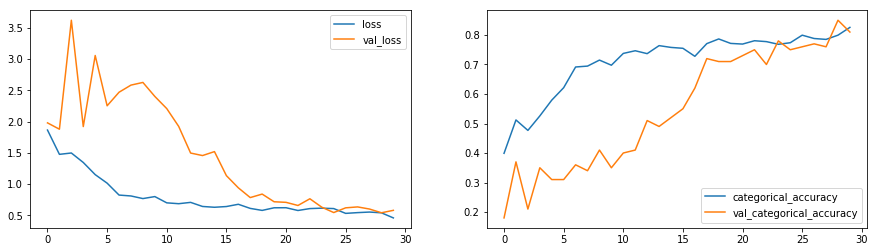

In [15]:
plot(history_model4)

With more layers we dont see much performance improvement. Best validation accuracy = 76% . Let's add dropouts at the convolution layers

# Model 5
Adding dropout at convolution layers

In [16]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [18]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
33/34 [============================>.] - ETA: 5s - loss: 1.7347 - categorical_accuracy: 0.3970 
Epoch 00001: saving model to model_init_2020-12-2805_44_48.018306/model-00001-1.73547-0.39668-2.24750-0.24000.h5
34/34 [==============================] - 201s 6s/step - loss: 1.7394 - categorical_accuracy: 0.3951 - val_loss: 2.2475 - val_categorical_accuracy: 0.2400
Epoch 2/22
33/34 [============================>.] - ETA: 4s - loss: 1.2254 - categorical_accuracy: 0.5280
Epoch 00002: saving model to model_init_2020-12-2805_44_48.018306/model-00002-1.22543-0.52790-2.43862-0.13000.h5
34/34 [==============================] - 173s 5s/step - loss: 1.2257 - categorical_accuracy: 0.5272 - val_loss: 2.4386 - val_categorical_accuracy: 0.1300
Epoch 3/22
33/34 [============================>.] - ETA: 4s - loss: 1.0490 - categorical_accuracy: 0.6152
Epoch 00003: saving model to model_init_2020-12-2805_44_48.018306/model-00003-1.05544-0.61312-2.72882-0.20000.h5
34/34 [=====

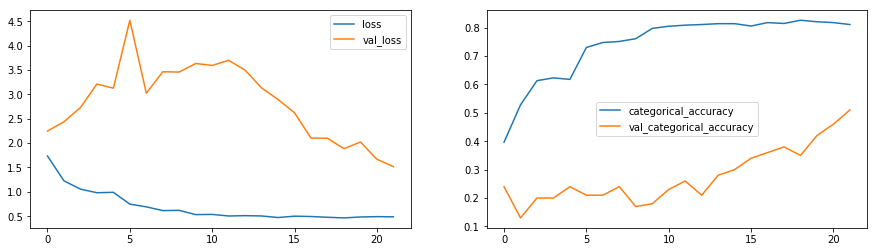

In [19]:
plot(history_model5)

Adding dropouts has further reduced validation accuracy as its not to learn  generalizable features

Let's try to reduce the model size and see the performance

# Model 6
Reducing the number of parameters

In [20]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=64,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_20 (Activation)   (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_21 (Activation)   (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 8, 60, 60, 16)     64        
__________

In [22]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 230949
Epoch 1/30
33/34 [============================>.] - ETA: 4s - loss: 2.0517 - categorical_accuracy: 0.3045
Epoch 00001: saving model to model_init_2020-12-2806_48_58.558833/model-00001-2.04992-0.30468-1.66249-0.16000.h5
34/34 [==============================] - 183s 5s/step - loss: 2.0405 - categorical_accuracy: 0.3054 - val_loss: 1.6625 - val_categorical_accuracy: 0.1600
Epoch 2/30
33/34 [============================>.] - ETA: 4s - loss: 1.5161 - categorical_accuracy: 0.4394
Epoch 00002: saving model to model_init_2020-12-2806_48_58.558833/model-00002-1.51632-0.43816-2.03305-0.19000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.5175 - categorical_accuracy: 0.4316 - val_loss: 2.0330 - val_categorical_accuracy: 0.1900
Epoch 3/30
33/34 [============================>.] - ETA: 4s - loss: 1.3307 - categorical_accuracy: 0.4894
Epoch 00003: saving model to model_init_2020-12-2806_48_58.558833/model-00003-1.33361-0.48793-2.57593-0.13000.h5
34/34 [=======

Epoch 23/30
33/34 [============================>.] - ETA: 4s - loss: 0.8973 - categorical_accuracy: 0.6394
Epoch 00023: saving model to model_init_2020-12-2806_48_58.558833/model-00023-0.90025-0.63876-1.01030-0.66000.h5
34/34 [==============================] - 161s 5s/step - loss: 0.9162 - categorical_accuracy: 0.6354 - val_loss: 1.0103 - val_categorical_accuracy: 0.6600
Epoch 24/30
33/34 [============================>.] - ETA: 4s - loss: 0.8950 - categorical_accuracy: 0.6644
Epoch 00024: saving model to model_init_2020-12-2806_48_58.558833/model-00024-0.89421-0.66365-0.93302-0.66000.h5
34/34 [==============================] - 162s 5s/step - loss: 0.8900 - categorical_accuracy: 0.6597 - val_loss: 0.9330 - val_categorical_accuracy: 0.6600
Epoch 25/30
33/34 [============================>.] - ETA: 4s - loss: 0.9171 - categorical_accuracy: 0.6553
Epoch 00025: saving model to model_init_2020-12-2806_48_58.558833/model-00025-0.91925-0.65535-0.91726-0.70000.h5
34/34 [=========================

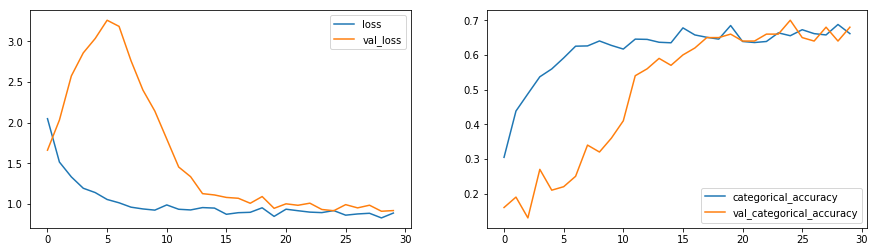

In [23]:
plot(history_model6)

For the above low memory foot print model the best validation accuracy of 78%

# Model 7
Implementing a CNN LSTM Model

In [24]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [26]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model7=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
33/34 [============================>.] - ETA: 7s - loss: 1.4454 - categorical_accuracy: 0.3720 
Epoch 00001: saving model to model_init_2020-12-2808_10_34.079482/model-00001-1.44490-0.37179-1.64519-0.15000.h5
34/34 [==============================] - 286s 8s/step - loss: 1.4421 - categorical_accuracy: 0.3709 - val_loss: 1.6452 - val_categorical_accuracy: 0.1500
Epoch 2/20
33/34 [============================>.] - ETA: 4s - loss: 1.1560 - categorical_accuracy: 0.5250
Epoch 00002: saving model to model_init_2020-12-2808_10_34.079482/model-00002-1.15317-0.52715-1.97900-0.19000.h5
34/34 [==============================] - 168s 5s/step - loss: 1.1379 - categorical_accuracy: 0.5386 - val_loss: 1.9790 - val_categorical_accuracy: 0.1900
Epoch 3/20
33/34 [============================>.] - ETA: 4s - loss: 0.9793 - categorical_accuracy: 0.6076
Epoch 00003: saving model to model_init_2020-12-2808_10_34.079482/model-00003-0.97631-0.60935-2.26500-0.20000.h5
34/34 [=====

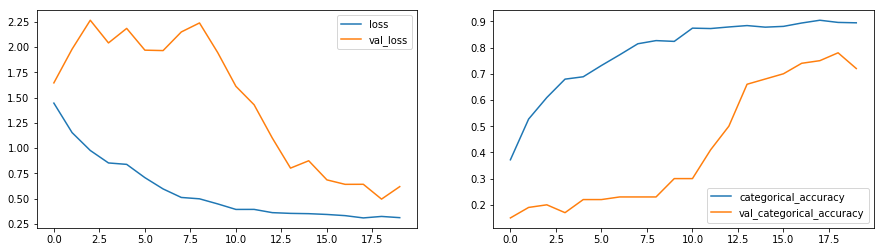

In [27]:
plot(history_model7)

For CNN - LSTM model we got a best validation accuracy of 75%

##### As we see more cases of overfitting, lets augment the data and run the same set of models again

##### Adding More Augmentation

In [23]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model 8
(3,3,3) Filter & 160x160 Image resolution - Like Model no. 2

In [24]:
class ModelConv3D8(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=160,image_width=160)
conv_3d8.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=256,dropout=0.5)
conv_3d8_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 80, 80, 32)    128       
__________

In [26]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
33/34 [============================>.] - ETA: 11s - loss: 2.0583 - categorical_accuracy: 0.3470
Epoch 00001: saving model to model_init_2020-12-2811_10_01.729522/model-00001-2.05492-0.34842-2.34308-0.16000.h5
34/34 [==============================] - 440s 13s/step - loss: 2.0367 - categorical_accuracy: 0.3561 - val_loss: 2.3431 - val_categorical_accuracy: 0.1600
Epoch 2/30
33/34 [============================>.] - ETA: 6s - loss: 1.4695 - categorical_accuracy: 0.5061 
Epoch 00002: saving model to model_init_2020-12-2811_10_01.729522/model-00002-1.46648-0.50754-4.03282-0.17000.h5
34/34 [==============================] - 254s 7s/step - loss: 1.4502 - categorical_accuracy: 0.5155 - val_loss: 4.0328 - val_categorical_accuracy: 0.1700
Epoch 3/30
33/34 [============================>.] - ETA: 7s - loss: 1.1283 - categorical_accuracy: 0.6045 
Epoch 00003: saving model to model_init_2020-12-2811_10_01.729522/model-00003-1.13118-0.60332-5.29660-0.21000.h5
34/34 [==

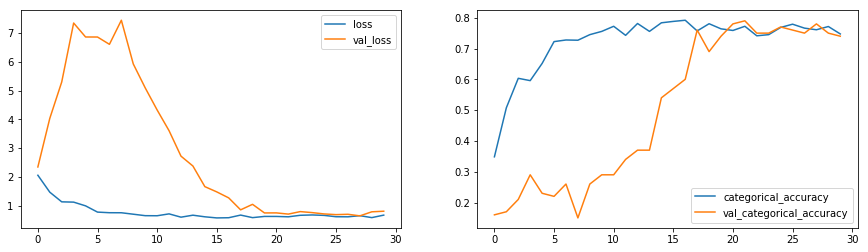

In [27]:
plot(history_model8)

# Model 9
(2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [28]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=120,image_width=120)
conv_3d9.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d9_model=conv_3d9.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_17 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 60, 60, 32)     128       
__________

In [30]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
22/23 [===========================>..] - ETA: 9s - loss: 2.2477 - categorical_accuracy: 0.2864 
Epoch 00001: saving model to model_init_2020-12-2813_24_01.534298/model-00001-2.24632-0.28658-1.81173-0.21000.h5
23/23 [==============================] - 241s 10s/step - loss: 2.2353 - categorical_accuracy: 0.2883 - val_loss: 1.8117 - val_categorical_accuracy: 0.2100
Epoch 2/30
22/23 [===========================>..] - ETA: 6s - loss: 1.5274 - categorical_accuracy: 0.4742 
Epoch 00002: saving model to model_init_2020-12-2813_24_01.534298/model-00002-1.52739-0.47360-2.83961-0.20000.h5
23/23 [==============================] - 158s 7s/step - loss: 1.5271 - categorical_accuracy: 0.4683 - val_loss: 2.8396 - val_categorical_accuracy: 0.2000
Epoch 3/30
22/23 [===========================>..] - ETA: 6s - loss: 1.3291 - categorical_accuracy: 0.5371 
Epoch 00003: saving model to model_init_2020-12-2813_24_01.534298/model-00003-1.32534-0.53846-3.61442-0.23000.h5
23/23 [==

Epoch 22/30
22/23 [===========================>..] - ETA: 6s - loss: 0.8221 - categorical_accuracy: 0.6977 
Epoch 00022: saving model to model_init_2020-12-2813_24_01.534298/model-00022-0.82461-0.69759-2.29945-0.36000.h5
23/23 [==============================] - 168s 7s/step - loss: 0.8450 - categorical_accuracy: 0.6964 - val_loss: 2.2994 - val_categorical_accuracy: 0.3600
Epoch 23/30
22/23 [===========================>..] - ETA: 6s - loss: 0.8880 - categorical_accuracy: 0.6727 
Epoch 00023: saving model to model_init_2020-12-2813_24_01.534298/model-00023-0.88635-0.67345-2.23350-0.34000.h5
23/23 [==============================] - 171s 7s/step - loss: 0.8728 - categorical_accuracy: 0.6794 - val_loss: 2.2335 - val_categorical_accuracy: 0.3400
Epoch 24/30
22/23 [===========================>..] - ETA: 6s - loss: 0.8890 - categorical_accuracy: 0.6689 
Epoch 00024: saving model to model_init_2020-12-2813_24_01.534298/model-00024-0.89104-0.66742-1.87041-0.43000.h5
23/23 [======================

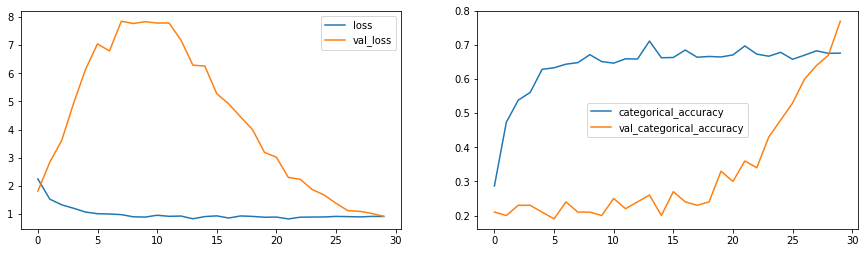

In [31]:
plot(history_model9)

# Model 10
CNN LSTM with GRU - Similar to Model 7

In [38]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [40]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model13=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
33/34 [============================>.] - ETA: 6s - loss: 1.5042 - categorical_accuracy: 0.3659 
Epoch 00001: saving model to model_init_2020-12-2815_29_25.572726/model-00001-1.50481-0.36576-2.09685-0.21000.h5
34/34 [==============================] - 255s 8s/step - loss: 1.5083 - categorical_accuracy: 0.3650 - val_loss: 2.0969 - val_categorical_accuracy: 0.2100
Epoch 2/20
33/34 [============================>.] - ETA: 4s - loss: 1.0350 - categorical_accuracy: 0.6083
Epoch 00002: saving model to model_init_2020-12-2815_29_25.572726/model-00002-1.03844-0.60633-2.88573-0.21000.h5
34/34 [==============================] - 178s 5s/step - loss: 1.0568 - categorical_accuracy: 0.5957 - val_loss: 2.8857 - val_categorical_accuracy: 0.2100
Epoch 3/20
33/34 [============================>.] - ETA: 4s - loss: 0.8776 - categorical_accuracy: 0.6682
Epoch 00003: saving model to model_init_2020-12-2815_29_25.572726/model-00003-0.87840-0.66742-3.39717-0.17000.h5
34/34 [=====

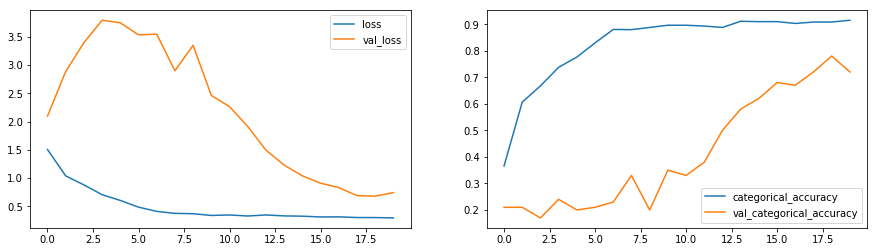

In [41]:
plot(history_model13)